In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

We're loading the data directly from disk inside the notebook, which is fine for now. Later, we’ll move this logic into reusable scripts.

In [6]:
df = pd.read_csv("../data/Hotel_Reservations.csv")
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


For quick prototypes, use visual inspection. In production, you’d automate profiling (e.g., with pandas-profiling or ydata-profiling)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

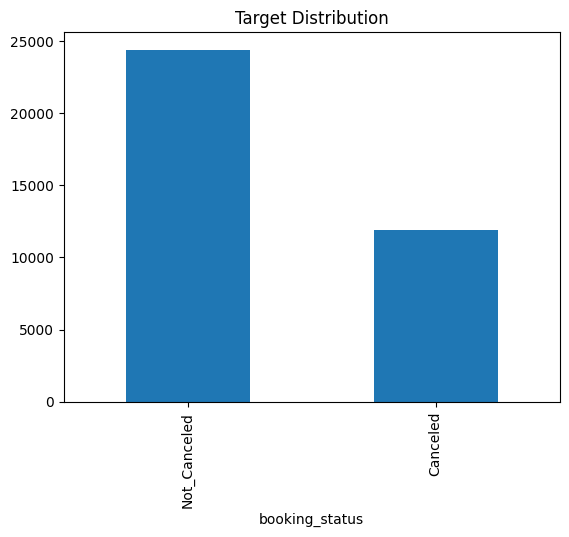

In [ ]:
df.info()
df.describe()
df["booking_status"].value_counts().plot(kind="bar", title="Target Distribution")
plt.show()

In [ ]:
# --- 1. Feature Engineering ---
# Convert to datetime and extract features
df["arrival_date_full"] = pd.to_datetime(
    df["arrival_year"].astype(str)
    + "-"
    + df["arrival_month"].astype(str)
    + "-"
    + df["arrival_date"].astype(str),
    errors="coerce",
)
df["day_of_week"] = df["arrival_date_full"].dt.dayofweek
df["is_weekend"] = (df["arrival_date_full"].dt.dayofweek >= 5).astype(int)
df["month"] = df["arrival_date_full"].dt.month

# Drop original date columns and Booking_ID
df_processed = df.drop(
    columns=[
        "Booking_ID",
        "arrival_year",
        "arrival_month",
        "arrival_date",
        "arrival_date_full",
    ]
)

# Encode the target variable
df_processed["booking_status"] = df_processed["booking_status"].map(
    {"Canceled": 1, "Not_Canceled": 0}
)

# --- 2. Define Features and Target ---
X = df_processed.drop("booking_status", axis=1)
y = df_processed["booking_status"]

# Define categorical and numerical features
categorical_features = [
    "type_of_meal_plan",
    "room_type_reserved",
    "market_segment_type",
]
numerical_features = [col for col in X.columns if col not in categorical_features]

# --- 3. Create Preprocessing Pipelines ---
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# --- 4. Combine Preprocessing Steps with ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [9]:
# --- 5. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# --- 6. Create the Full Model Pipeline ---
model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(class_weight="balanced", random_state=42),
        ),
    ]
)

In [ ]:
# --- 7. Define Hyperparameter Search Space ---
# Note the 'classifier__' prefix for pipeline parameters
param_dist = {
    "classifier__n_estimators": [100, 300, 500],
    "classifier__max_depth": [None, 10, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 5],
    "classifier__max_features": ["sqrt", "log2", None],
}

In [12]:
# --- 8. Setup and Run Hyperparameter Search ---
search = GridSearchCV(
    model_pipeline,
    param_grid=param_dist,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring="f1_macro",
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/Users/sarahg/Documents/Coding/HotelReservation_MLflow/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['no_of_adults',
                                                                          'no_of_children',
                                                                          'no_of_weekend_nights',
                                                                          'no_of_week_nights',
                                                                          'required_car_parking_space',
                                                                          'lead_time',
                                                                          'repeated_guest',
                                                                          'no_of_previous_cancellati...
                                                                          'market_segment_type'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 30],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__min_samples_leaf': [1, 5],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 300, 500]},
             scoring='f1_macro', verbose=1)

In [13]:
print(search.best_params_)

{'classifier__max_depth': 30, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 500}


In the next phases, we’ll want to track these metrics and results automatically using tools like MLflow.

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4878
           1       0.87      0.83      0.85      2377

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255


--- Confusion Matrix ---


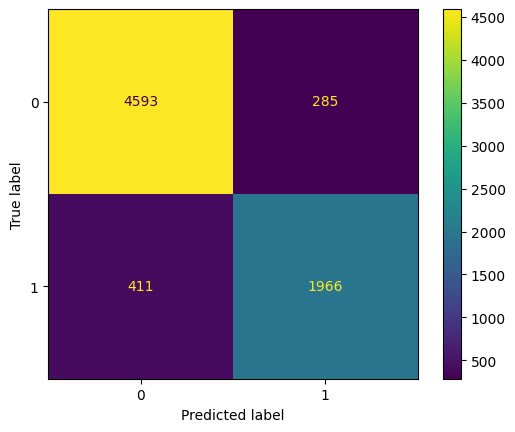

In [14]:
# --- 9. Evaluate the Best Model ---
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [15]:
# --- 10. Feature Importance ---

# Extract classifier from the pipeline
classifier = best_model.named_steps["classifier"]

# Get feature names after one-hot encoding
ohe_feature_names = (
    preprocessor.named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)

# Combine with numerical feature names
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Create a series for easy plotting
importances = pd.Series(classifier.feature_importances_, index=all_feature_names)

# Plot
plt.figure(figsize=(12, 8))
importances.sort_values().plot(kind="barh", title="Feature Importances")
plt.tight_layout()
plt.show()

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'